<span style="font-family:Papyrus; font-size:3em;">Testing Kinetics Models</span>

<span style="font-family:Papyrus; font-size:2em;">Finding Mass Balance Errors</span>

This notebook discusses the detection of one kind of static tests, mass balance errors.

# Programminmg Preliminaries

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    COMMON_DIR = "/home/ubuntu/advancing-biomedical-models/common"
    CODE_DIRS = [COMMON_DIR]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_15"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    COMMON_DIR = ["/content/drive/MyDrive/Winter 2021/common"]
    CODE_DIRS = [COMMON_DIR]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/15_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

In [10]:
# Python packages used in this section
import os
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from SBMLLint.tools.sbmllint import lint

# Motivating Example

Static testing is done by analyzing the model without running any simulation.
Several kinds of errors can be discovered by a static analysis.

## Mass Balance Errors

A first error is the presence of reactions that do not preserve mass balance. Consider the following simulation of ``ATP`` hydrolysis and ``ADP`` phosphorylation. in which the equilibrium constant (``Keq``) is 1. We not that this is not a physiological value for ``Keq``, but useful for our example.

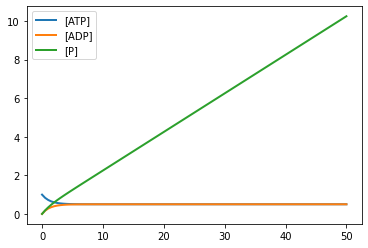

In [3]:
ATP1_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP1_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Our expectation is that at equilibrium, ``ATP = ADP`` by definition of the equilibrium constant. However, instead ``Pi_`` increases without bound,
and ``ATP = 0 = ADP``.

Clearly, we have an error in the model. What is it?

The issue here is that there is mass balance error in the model.
That is, non-boundary reactions (reactions with non-null reactants and non-null products) should neither creater nor destroy mass.
This is the case for ``J0`` in that the third inorganic phosphate in ``ATP`` is one of the products.
However, there is no inorganic phosphate in the reactants of ``J1``. So, we are creating ``P`` in this network.

Below, we revise the model to include ``P`` in the reactants of ``J1a``.

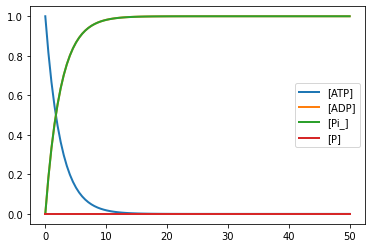

In [4]:
ATP2_MODEL = """
J0: ATP -> ADP + Pi_; k_f*ATP  
J1a: ADP + P -> ATP; k_r*ADP*P

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP2_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Now, we get a more reasonable result. (Note that the line for ``ADP`` and ``Pi`` are coincident.) The concentrations of ``ATP`` and ``ADP`` differ because $K_{eq} = \frac{[ATP]}{[ADP] [Pi]} = \frac{0.64}{(0.4)(0.4)}$.

There is another way of fixing the mass balance error that reqults in ``ATP = ADP``. This solution assumes that there is a
large concentration of ``Pi`` that is relatively unchanged as a result of the hydolysis and phosphorylation reactions.
So, ``Pi`` does not appear in the model.

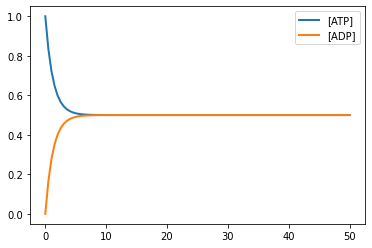

In [5]:
ATP3_MODEL = """
J0a: ATP -> ADP; k_f*ATP 
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP3_MODEL)
rr.plot(rr.simulate(0, 50, 100))

# Detecting Mass Balance Errors

Having seen the dramatic impact of undetected mass balance errors, it is natural to ask how they can be detected. There are two general approaches.
The first requires knowing the chemical composition of each chemical species.
For example, atomic mass analysis ??ref-MEMOTE counts the atoms of each type in the reactants and compares each count with the corresponding counts of atoms in the products.
This approach has two challenges.
First, the modeler must use annotations or other means to expose the chemical structure of species; this is not always available (especially
for larger molecules that can be in many different chemical states of phosphorylation, methylation, etc.).
A second problem is that it forces the modeler to write unnecessarly detailed reactions.
For example, ``ATP2_MODEL`` fails this kind of mass balance checking because there is no accounting for the $\gamma$ phosphate of ``ATP``.

An alternative approach is to check for a condition that is a bit weaker than mass balance.
Referred to as **stoichiometric inconsistency**, such inconsistencies are detected if there is no assignment of masses to
the chemical species such that the reaction network (without boundary reactions) neither creates nor destroys chemical species.

The technical details of this latter approach are described in ??ref-Shin for details.
The paper introduces the GAMES algorithm that uses graphical techniques to analyze mass equivalences implied by the reaction network.
For example, reaction ``J0`` implies that the mass of ``ATP`` is equal to the sum of the masses of ``ADP`` and ``P``.

GAMES is in the SBMLLint ``pip`` installable package. It can be run at the command line
via ``games <SBML file>``. It can also be run programmatically, such as within a Jupyter notebook.
Below, we show how to apply the GAMES to the above examples.


In [6]:
_ = lint(ATP1_MODEL, mass_balance_check="games")

Model analyzed...
At least one error found.


ADP = ATP by reaction(s):
1. J1: ADP -> ATP

However, ADP < ATP by reaction(s):
2. J0: ATP -> ADP + P


----------------------------------------------------------------------



**********************************************************************




GAMES detected that the first model is stoichiometric inconsisent. Further, GAMES provides a simple argument for how this detection is made.
Statement (1) explains that GAMES inferred that the mass of ``ADP`` is equal to the mass of ``ATP``.
However, this is contradicted by a second finding that the mass of ``ADP`` is less than the mass of ``ATP``.

In [7]:
_ = lint(ATP2_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


In [8]:
_ = lint(ATP3_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


# Other Errors Detectable By Static Analysis

There are other errors in reaction networks that can be detected statically. Systems such as MEMOTE detect the following errors:
- *Blocked reactions* are reactions where one or more reactant is never present and so the reaction never ocurs.
- *Dead end metabolite* are chemical species that are produced but not consumed.
- *Orphan metabolites* are chemical species that are consumed but not produced.
- *Charge imbalance* reactions are reactions that do not preserve the charge of the reactants in the products.

The foregoing errors apply to the mass transfer part of reactions. Of course, errors are also possible in the kinetics laws.
Among these errors are:
- *Incorrect reference to chemical species*. To illustrate, consider a reaction in which the modeler intended to use mass action kinetcs, but
wrote the reaction as ``A -> B; kB``.
- *Errors in the function used in the kinetics law*. A common example here is to inadevertently use zeroth order kinetics for
the degradation of a chemical species.
For example, ``B ->; k``. The problem is that this can result in ``B`` becoming negative since its value is reduced
regardless of whether ``B`` is present. Clearly, we cannot have a negative concentration.

# Application to Glycolytic Oscillations
This section applies the idea of model testing to our running example of glycolytic oscillations.
We begin by introduce several constants.
Constants are in all capital letters; they are assigned once, and their values do not change.

In [11]:
# Constants used in the section
WOLF_MODEL = os.path.join(COMMON_DIR, "Jana_WolfGlycolysis.antimony")
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME
ROADRUNNER = te.loada(WOLF_MODEL)

In this section, we consider tests to verify the simulation of glycolytic oscillations used in our running example. The use case considered is one in which a team plans to modify the original model.
This may involve both the addition and removal of reactions.

Recall that the reactions in this model are:

  ``
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;``

We begin by checking if the Wolf model has any stoichiometric inconsistencies.
First, we create the antimony model as a string.

In [ ]:
WOLF_ANTIMONY = ROADRUNNER.getAntimony()

Then, we check it.

In [ ]:
_ = lint(WOLF_ANTIMONY, mass_balance_check="games")

# Apply to BioModels

**Question**
Download the following models from BioModels, and check for mass balance errors.